In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/modified-spotify-2/modified_dataset.txt
/kaggle/input/final-dataset-msc-1/assistant_label_responses.txt
/kaggle/input/modified-labelled-spotify/modified_dataset.txt
/kaggle/input/final-msc/assistant_label_responses.txt
/kaggle/input/openai/assistant_label_responses.txt
/kaggle/input/labelled-music/formatted_dataset_labelled.txt
/kaggle/input/final-dataset-msc/assistant_label_responses.txt
/kaggle/input/modified-spotify/modified_dataset.txt
/kaggle/input/spotify-app-reviews-2022/reviews.csv
/kaggle/input/final-dataset/assistant_label_responses.txt


Import libraries

In [2]:
import pandas as pd
import torch
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings

Import file

In [3]:
import pandas as pd

datafile = '/kaggle/input/spotify-app-reviews-2022/reviews.csv'
df = pd.read_csv(datafile, encoding="utf-8")


df.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


Understand Data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61594 entries, 0 to 61593
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Time_submitted  61594 non-null  object
 1   Review          61594 non-null  object
 2   Rating          61594 non-null  int64 
 3   Total_thumbsup  61594 non-null  int64 
 4   Reply           216 non-null    object
dtypes: int64(2), object(3)
memory usage: 2.3+ MB


Remove URLS

In [5]:
import re


def remove_url(text):
    text = re.sub(r"http\S+", "", text)
    return text


# Example string with weird font characters plus an URL which we gonna remove.
sample = "ℍ𝕚 𝔼𝕧𝕖𝕣𝕪𝕠𝕟𝕖 \n https://www.kaggle.com/ 😊"
print(f"Text before removing url:- \n {sample}")

sample = remove_url(sample)
print(f"Text after removing url:- \n {sample}")

Text before removing url:- 
 ℍ𝕚 𝔼𝕧𝕖𝕣𝕪𝕠𝕟𝕖 
 https://www.kaggle.com/ 😊
Text after removing url:- 
 ℍ𝕚 𝔼𝕧𝕖𝕣𝕪𝕠𝕟𝕖 
  😊


Normalise unicode data

In [6]:
import unicodedata as uni

print(f"Text before Unicode Normalization:- \n {sample}")

sample = uni.normalize('NFKD', sample)
print(f"Text after Unicode Normalization:- \n {sample}")

Text before Unicode Normalization:- 
 ℍ𝕚 𝔼𝕧𝕖𝕣𝕪𝕠𝕟𝕖 
  😊
Text after Unicode Normalization:- 
 Hi Everyone 
  😊


Install Demoji library

In [7]:
!pip install demoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 2.1 MB/s eta 0:00:00


Clean emojis

In [8]:
import demoji


def handle_emoji(string):
    emojis = demoji.findall(string)

    for emoji in emojis:
        string = string.replace(emoji, " " + emojis[emoji].split(":")[0])

    return string


print(f"Before Handling emoji:- \n {sample}")
print(f"After Handling emoji:- \n {handle_emoji(sample)}")

Before Handling emoji:- 
 Hi Everyone 
  😊
After Handling emoji:- 
 Hi Everyone 
   smiling face with smiling eyes


Tokenise words

In [9]:
def word_tokenizer(text):
    text = text.lower()
    text = text.split()

    return text


sample = "Hi Everyone I really love the playlists on this app."
print(sample)
print(word_tokenizer(sample))


Hi Everyone I really love the playlists on this app.
['hi', 'everyone', 'i', 'really', 'love', 'the', 'playlists', 'on', 'this', 'app.']


Here I created a custome list of stopwords including sentiment words, and the name of the app as well as other unimportant words

In [10]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
#Adding in extra stopwords related to sentiment and unneeded characters
custom_stopwords = ["spotify", "i", "I", "app", "happy", "sad", "work", "hi", "fun", "idk", "lol", "ive", "trash", "god", "guys", "dont", "worst", "days", "right", "thanks", "lots", "week", "nice", "kind", "day", "ca", "garbage", "today", "sucks", "awesome", "everytime", "bit", "thank", "easy", "things", "keeps", "people", "lot", "thing", "way", "times", "im", "angry", "ve", "music", "great", "don", "want", "good", "really", "love", "hate", "songs", "song", "like", "just"]
en_stopwords = set(stopwords.words('english'))
all_stopwords = set(custom_stopwords).union(set(ENGLISH_STOP_WORDS).union(en_stopwords))
print(f"Stop Words in English : \n{ all_stopwords}")

Stop Words in English : 
{'name', 'aren', 'also', 'until', 'due', 't', 'con', 'well', 'haven', 'herself', 'indeed', 'fifteen', 'thereby', 'hereafter', "she's", 'nevertheless', 'weren', 'thick', 'o', 'ten', 'up', "haven't", 'nothing', 'had', 'beyond', 'cry', 'there', 'sixty', 'though', 'that', 'wherein', 'whither', 'thing', 'along', 'couldnt', 'bottom', 'our', 'worst', 'twenty', 'onto', 'next', 'needn', 'ca', 'if', 'through', 'about', 'hers', 'because', 'this', 'less', "hadn't", 'happy', 'found', 'things', 'might', 'per', "you've", 'nobody', 'sometimes', 'wherever', 'no', 'a', "it's", 'two', 'keep', 'the', 'is', 'six', 'many', 'several', 'anyone', 'be', "mightn't", 'others', 'in', 'namely', 'very', 'these', 'it', 'didn', 'its', 'ain', 'she', 'after', 'thru', 'll', 'each', 'won', 'within', 'co', 'sincere', 'inc', 'noone', 'hence', 'cannot', 'third', 'fun', 'am', 'latter', 'just', 'already', 'hasnt', 'most', 'yourselves', 'made', 'call', 'yours', 'mustn', 'thin', 'four', 'such', 'hasn', '

Remove Stopwords function

In [11]:

def remove_stopwords(text):
    text = [word for word in text if word not in all_stopwords]
    return text


print(f"Before removing stopwords : {word_tokenizer(sample)}")
print(f"After removing stopwords : {remove_stopwords(word_tokenizer(sample))}")

Before removing stopwords : ['hi', 'everyone', 'i', 'really', 'love', 'the', 'playlists', 'on', 'this', 'app.']
After removing stopwords : ['playlists', 'app.']


Lemmatisation step below

In [12]:
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer

stemmer = PorterStemmer()


def stemming(text):

    text = [stemmer.stem(word) for word in text]
    return text


sample = "I am creating a Notebook"
print(f"Before Stemming : {(sample)}")
print(f"After Stemming : {stemming(word_tokenizer(sample))}")

Before Stemming : I am creating a Notebook
After Stemming : ['i', 'am', 'creat', 'a', 'notebook']


Import Spacy

In [13]:
import spacy

sp = spacy.load("en_core_web_sm")

Alternative lemmatisation using Spacy library

In [14]:
def lemmatization(text):

    # text = [sp(word).lemma_ for word in text]

    text = " ".join(text)
    token = sp(text)

    text = [word.lemma_ for word in token]
    return text


print(f"Before Lemmatization : {word_tokenizer(sample)}")
print(f"After Lemmatization : {lemmatization(word_tokenizer(sample))}")

Before Lemmatization : ['i', 'am', 'creating', 'a', 'notebook']
After Lemmatization : ['I', 'be', 'create', 'a', 'notebook']


Define pre-processing function

In [15]:
from gensim.models import Phrases

def preprocessing(text):
    
    text = remove_url(text) 
    text = uni.normalize('NFKD', text)
    text = handle_emoji(text)
    text = text.lower() 
    text = re.sub(r'[^\w\s]', '', text)
    text = word_tokenizer(text)
    # text = stemming(text)
    text = lemmatization(text)
    text = remove_stopwords(text)

    text = " ".join(text)
    return text

Apply pre-processing

In [16]:
from tqdm import tqdm

tqdm.pandas()

df['clean_review'] = df['Review'].progress_apply(lambda x: preprocessing(x))


100%|██████████| 61594/61594 [14:49<00:00, 69.24it/s]


See what cleaned review looks like

In [17]:
df.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply,clean_review
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN,service audio high quality use quick friendly ...
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN,ignore previous negative rating super star
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN,popup experience android 12 annoying let rid
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN,buggy terrible use recently
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN,dear playlist shuffle play


Tokenise clean review

In [18]:
from tqdm import tqdm
tqdm.pandas()

df['clean_review2'] = df['clean_review'].progress_map(word_tokenizer)
data_words = df['clean_review2'].values.tolist()

df.head(20)



100%|██████████| 61594/61594 [00:00<00:00, 242495.88it/s]


,Time_submitted,Review,Rating,Total_thumbsup,Reply,clean_review,clean_review2
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN,service audio high quality use quick friendly ...,"[service, audio, high, quality, use, quick, fr..."
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN,ignore previous negative rating super star,"[ignore, previous, negative, rating, super, star]"
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN,popup experience android 12 annoying let rid,"[popup, experience, android, 12, annoying, let..."
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN,buggy terrible use recently,"[buggy, terrible, use, recently]"
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN,dear playlist shuffle play,"[dear, playlist, shuffle, play]"
5,2022-07-09 13:20:20,The player controls sometimes disappear for no...,3,7,NaN,player control disappear reason restart forget...,"[player, control, disappear, reason, restart, ..."
6,2022-07-09 13:19:21,I love the selection and the lyrics are provid...,5,0,NaN,selection lyric provide listen,"[selection, lyric, provide, listen]"
7,2022-07-09 13:17:22,Still extremely slow when changing storage to ...,3,16,NaN,extremely slow change storage external sd card...,"[extremely, slow, change, storage, external, s..."
8,2022-07-09 13:16:49,It's a great app and the best mp3 music app I ...,5,0,NaN,mp3 use problem play despite wonderful recommend,"[mp3, use, problem, play, despite, wonderful, ..."
9,2022-07-09 13:11:32,"I'm deleting this app, for the following reaso...",1,318,NaN,delete follow reason fail business model strea...,"[delete, follow, reason, fail, business, model..."


Create list of all words

In [19]:
data_words = df['clean_review2'].values.tolist()
len(data_words)
all_words = df['Review'].values.tolist()

Create a disctionary and corpus

In [20]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
corpus_bigram = [id2word.doc2bow(doc) for doc in data_words]
# View
print(corpus[:1][0][:30])



[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]


Example preprocessing 

In [21]:

tokenized_corpus = [[id2word[word_id] for (word_id, count) in doc] for doc in corpus]

processed_text = preprocessing("I love spotify so much it's the best thing every and I'm impressed by the audio quality")
print(processed_text)

impressed audio quality


LDA model building for topic modelling

In [22]:
from gensim.models import LdaMulticore
from gensim.models import LdaModel
from pprint import pprint

# number of topics
num_topics = 10
# Build LDA model
lda_model = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics, iterations=400)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


[(0,
  '0.093*"ad" + 0.027*"premium" + 0.020*"free" + 0.019*"add" + 0.018*"30" + '
  '0.017*"minute" + 0.016*"skip" + 0.014*"3" + 0.014*"listen" + 0.012*"use"'),
 (1,
  '0.036*"time" + 0.021*"use" + 0.018*"problem" + 0.018*"internet" + '
  '0.017*"connection" + 0.015*"fix" + 0.015*"stop" + 0.013*"device" + '
  '0.012*"update" + 0.012*"play"'),
 (2,
  '0.054*"use" + 0.031*"listen" + 0.031*"play" + 0.023*"ad" + 0.017*"playlist" '
  '+ 0.017*"make" + 0.016*"podcast" + 0.014*"enjoy" + 0.013*"premium" + '
  '0.010*"quality"'),
 (3,
  '0.039*"play" + 0.024*"listen" + 0.018*"podcast" + 0.014*"stop" + '
  '0.014*"playlist" + 0.012*"start" + 0.010*"add" + 0.010*"download" + '
  '0.010*"face" + 0.009*"bad"'),
 (4,
  '0.035*"listen" + 0.024*"lyric" + 0.024*"play" + 0.016*"use" + 0.016*"star" '
  '+ 0.014*"phone" + 0.013*"u" + 0.012*"experience" + 0.009*"fix" + '
  '0.009*"problem"'),
 (5,
  '0.064*"play" + 0.037*"playlist" + 0.026*"update" + 0.025*"listen" + '
  '0.019*"premium" + 0.017*"pay" + 0

Although topics aren't really well defined, I've manually chosen these labels from the topics for the further analysis:

advert
subscription_or_cost
song_selection
user_experience
comparison
audio_quality
support
podcasts
connectivity
podcast
recommendation
playlists

Below I will visualise the clusters from the LDA analysis

In [23]:
import numpy as np
from sklearn.manifold import TSNE
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import Label
from bokeh.palettes import Category10
output_notebook()

# Get Document-Topic Distributions
doc_topic_dists = np.zeros((len(corpus), num_topics))
for doc_num, doc_topics in enumerate(lda_model[corpus_bigram]):
    for topic, prob in doc_topics:
        doc_topic_dists[doc_num, topic] = prob
print(doc_topic_dists.shape)


# Use t-SNE to reduce dimensionality
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(doc_topic_dists)

# Visualising using Bokeh
n_topics = lda_model.num_topics
colormap = np.array(Category10[10])
_lda_keys = np.array(doc_topic_dists).argmax(axis=1).tolist()

# Finding the centroid of each topic
_mean_topic_vectors = []
for t in range(n_topics):
    if colormap[_lda_keys].tolist().count(colormap[t]) > 0:
        _mean_topic_vectors.append(tsne_lda[colormap[_lda_keys] == colormap[t]].mean(axis=0))
        
top_3_words_lda = []
for t in range(n_topics):
    topic_words = lda_model.show_topic(t, 3)
    words_for_topic = [word for word, score in topic_words]
    top_3_words_lda.append(", ".join(words_for_topic))
    



Loading BokehJS ...

(61594, 10)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 61594 samples in 0.107s...
[t-SNE] Computed neighbors for 61594 samples in 19.745s...
[t-SNE] Computed conditional probabilities for sample 1000 / 61594
[t-SNE] Computed conditional probabilities for sample 2000 / 61594
[t-SNE] Computed conditional probabilities for sample 3000 / 61594
[t-SNE] Computed conditional probabilities for sample 4000 / 61594
[t-SNE] Computed conditional probabilities for sample 5000 / 61594
[t-SNE] Computed conditional probabilities for sample 6000 / 61594
[t-SNE] Computed conditional probabilities for sample 7000 / 61594
[t-SNE] Computed conditional probabilities for sample 8000 / 61594
[t-SNE] Computed conditional probabilities for sample 9000 / 61594
[t-SNE] Computed conditional probabilities for sample 10000 / 61594
[t-SNE] Computed conditional probabilities for sample 11000 / 61594
[t-SNE] Computed conditional probabilities for sample 12000 / 61594
[t-SNE] Computed conditional probabil

The mean sigma is not great but this is fine for our type of analysis

In [24]:
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), width=700, height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=colormap[_lda_keys])
for t in range(n_topics):
    label = Label(x=_mean_topic_vectors[t][0], y=_mean_topic_vectors[t][1], 
                  text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot, notebook_handle=True)

Clusters are not well defined but this is fine as we were able to pre-define topics for our analysis below

Next to train the FastText model

In [25]:
# load in open-ai labelled data
input_path = '/kaggle/input/final-dataset-msc-1/assistant_label_responses.txt'
f = open(input_path,'r')

!head /kaggle/input/final-dataset-msc-1/assistant_label_responses.txt
!wc /kaggle/input/final-dataset-msc-1/assistant_label_responses.txt











  2176  66231 440379 /kaggle/input/final-dataset-msc-1/assistant_label_responses.txt


Preprocess training data

In [26]:
import re

def preprocess_text(text):
    # Add spaces around punctuation
    text = re.sub(r'([.\!?,"/()])', r' \1 ', text)
    
    # Convert uppercase to lowercase
    text = text.lower()
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

with open("/kaggle/input/final-dataset-msc-1/assistant_label_responses.txt", "r", encoding="utf-8") as infile:
    with open("spotify_final_msc-1.preprocessed.txt", "w", encoding="utf-8") as outfile:
        for line in infile:
            outfile.write(preprocess_text(line) + "\n")

Split training and validation data

In [27]:
import fasttext
!head -n 1741 /kaggle/input/final-dataset-msc-1/assistant_label_responses.txt > spotify.train
!tail -n 435 /kaggle/input/final-dataset-msc-1/assistant_label_responses.txt > spotify.valid
model = fasttext.train_supervised(input="spotify.train", lr=0.5, epoch=25, wordNgrams=2, bucket=200000, dim=50, loss='ova')
model.save_model("model_spotify_final.bin")

Read 0M words
Number of words:  5983
Number of labels: 13
Progress: 100.0% words/sec/thread:  904880 lr:  0.000000 avg.loss:  1.116965 ETA:   0h 0m 0s


Test in a sample review not from the training set

In [28]:
model.predict("Fails when I use on WiFi but I like it for my commute podcasts", k=20)

(('__label__podcast',
  '__label__song_selection',
  '__label__connectivity',
  '__label__user_experience',
  '__label__playlist',
  '__label__bug',
  '__label__account',
  '__label__support',
  '__label__audio_quality',
  '__label__advert',
  '__label__playlists',
  '__label__comparison',
  '__label__subscription_or_cost'),
 array([4.22514647e-01, 3.62979203e-01, 2.22710162e-01, 1.60276026e-01,
        1.74524877e-02, 1.71072234e-03, 1.14356913e-03, 1.00000034e-05,
        1.00000034e-05, 1.00000034e-05, 1.00000034e-05, 1.00000034e-05,
        1.00000034e-05]))

The model correctly has high probability for the above example for the aspects "adverts" and "subscription_or_cost" and a borderline acceptable weight for "user_experience". However, even though audio quality has the 4th most likely aspect(along with support), the probability is low

Calculate the optimel precision and recall picking the best threshold

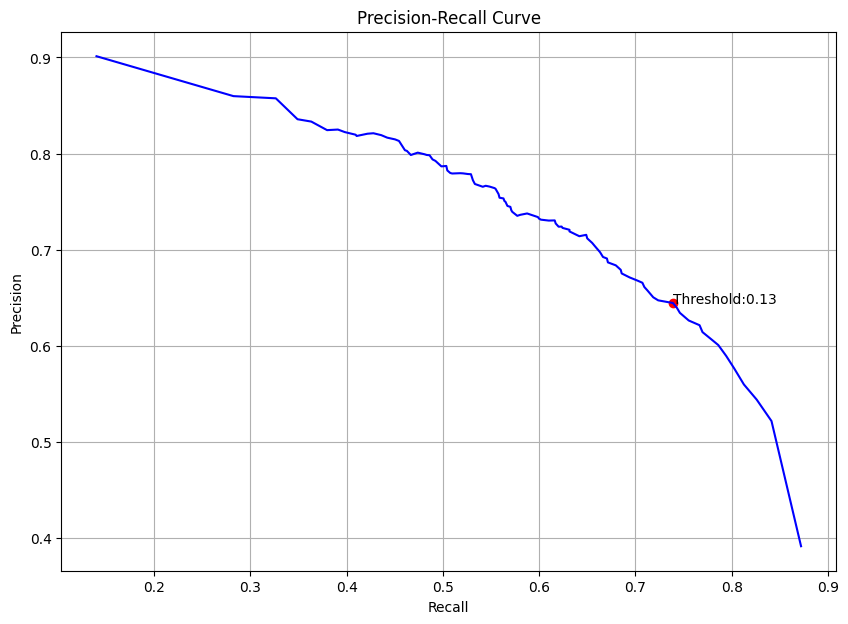

In [29]:
import numpy as np
import matplotlib.pyplot as plt

thresholds = np.linspace(0, 1, 100)  
precisions = []
recalls = []
f1_scores = []
num_labels = 5

for threshold in thresholds:
    _, precision, recall = model.test("spotify.valid", k=num_labels, threshold=threshold)
    
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(2 * (precision * recall) / (precision + recall))

# Plotting
plt.figure(figsize=(10,7))
plt.plot(recalls, precisions, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()

# Highlight the maximum F1-score point
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
plt.scatter(recalls[optimal_idx], precisions[optimal_idx], color='red')
plt.annotate(f'Threshold:{optimal_threshold:.2f}', (recalls[optimal_idx], precisions[optimal_idx]))

plt.show()


Calculate precision and recall using optimal threshold. 

In [30]:
threshold = optimal_threshold
model.test("spotify.valid", k=num_labels, threshold=threshold)

(435, 0.6446428571428572, 0.7389969293756398)

It's not a bad precision or recall - we can adjust the threshold hgiher for increased precision but there will be a tradeoff for recall
Define an aspect extraction function

In [31]:
def get_aspects(text):
    try:
        return model.predict(text, k=num_labels, threshold=threshold)
    except:
        return 0

In [32]:
tqdm.pandas(desc="Calculating Similarities")
df['label'] = df['Review'].progress_apply(lambda text: get_aspects(text))

Calculating Similarities: 100%|██████████| 61594/61594 [00:02<00:00, 30776.52it/s]


In [33]:
pd.set_option('display.max_colwidth', 100)
df.tail(5)

,Time_submitted,Review,Rating,Total_thumbsup,Reply,clean_review,clean_review2,label
61589,2022-01-01 03:01:29,"Even though it was communicated that lyrics feature is available for all users globally, after m...",1,6,NaN,communicate lyric feature available user globally 1 month later fix issue premium member feature...,"[communicate, lyric, feature, available, user, globally, 1, month, later, fix, issue, premium, m...","((__label__user_experience, __label__bug, __label__song_selection, __label__support), [0.8397439..."
61590,2022-01-01 02:13:40,"Use to be sooo good back when I had it, and when I downloaded (free version) you couldn't pick t...",1,0,NaN,use sooo download free version pick u play unless u pay online pay stuff probably premium vr pay...,"[use, sooo, download, free, version, pick, u, play, unless, u, pay, online, pay, stuff, probably...","((__label__subscription_or_cost, __label__user_experience, __label__song_selection, __label__acc..."
61591,2022-01-01 01:02:29,This app would be good if not for it taking over any device it is on. I start comp. There's Spot...,2,10,NaN,device start comp start start phone problem know change problem solve example little annoying li...,"[device, start, comp, start, start, phone, problem, know, change, problem, solve, example, littl...","((__label__user_experience, __label__song_selection, __label__bug, __label__support, __label__ac..."
61592,2022-01-01 00:49:23,The app is good hard to navigate and won't just let you play the song you click on just plays a ...,2,1,NaN,hard navigate let play click play playlist skip tell need premium skip need play click,"[hard, navigate, let, play, click, play, playlist, skip, tell, need, premium, skip, need, play, ...","((__label__song_selection, __label__user_experience, __label__advert, __label__playlist), [1.000..."
61593,2022-01-01 00:19:09,Its good but sometimes it doesnt load the music or it plays like 8 seconds of a song then stops ...,4,0,NaN,load play 8 second stop say wifiinternet connection diesnt time,"[load, play, 8, second, stop, say, wifiinternet, connection, diesnt, time]","((__label__user_experience, __label__song_selection, __label__bug, __label__connectivity), [1.00..."


In [34]:
import fasttext
from nltk.tokenize import sent_tokenize
import re
from transformers import pipeline

sentiment_pipeline = pipeline('sentiment-analysis')

def split_on_conjunctions(text):
    splits = re.split(r'\b(but|or|because|so|although|though|while)\b|\s*,\s*', text)
    return [s.strip() for s in splits if s]

def get_sentiment(text):
    result = sentiment_pipeline(text)
    return result[0]['label']

review = ("Easiest and most convenient way for a student to stream music," 
" but the app is plagued with issues, like pausing randomly on my Samsung" 
" S8 *edit* Issues still persist on Samsung S21. I'm paying so much for the "
"premium I wish it cost less but I kind of enjoy the listening to the podcasts "
"available. Don't get me started on eating milkshake and fries. " 
"The customer support is lacking but I like how easy connecting on wifi")
sentences = sent_tokenize(review)

label_sentiments = {}

for sentence in sentences:
    segments = split_on_conjunctions(sentence)
    for segment in segments:
        sentiment = get_sentiment(segment)
        if sentiment == 'POSITIVE':
            sentiment_label = "Positive"
        elif sentiment == 'NEGATIVE':
            sentiment_label = "Negative"
        else:
            sentiment_label = "Neutral"
        
        labels, probabilities = model.predict(segment, threshold=threshold, k=num_labels)
        
        for i, label in enumerate(labels):
            stripped_label = label.replace("__label__", "")
            if stripped_label not in label_sentiments or probabilities[i] > label_sentiments[stripped_label][1]:
                label_sentiments[stripped_label] = (sentiment_label, probabilities[i])

# Removing the probabilities and keeping only the sentiments for final output
final_sentiments = {label: sentiment[0] for label, sentiment in label_sentiments.items()}
print(final_sentiments)


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


{'song_selection': 'Positive', 'user_experience': 'Negative', 'bug': 'Negative', 'subscription_or_cost': 'Negative', 'account': 'Negative', 'podcast': 'Positive', 'connectivity': 'Positive'}


A great job on my sample review!